# Machine Intelligence II SoSe 2016 Exercise 8

The Nebenhoerers: Danijar Hafner, Thomas Kellermeier, Patrick Kuhn, Jan Szynal

In [1]:
%matplotlib inline

import scipy.io
import scipy.io.wavfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import collections
import random
import glob
from scipy import ndimage
from sklearn.decomposition import FastICA
import time
from scipy import signal
import random
import itertools

In [2]:
def plot(ax, data, **kwargs):
    ax.plot(data, **kwargs)
    ax.set_title(kwargs['label'])
    # scipy.io.wavfile.write(kwargs['label'] + '.wav', 8192, data),

seed = 13  # seed for random states to get always the same result

def generate_signals():
    timesteps = np.arange(0, 50.05, 0.05)
    signal1 = np.array([4 * np.sin(t - 3) for t in timesteps])
    signal2 = np.array([(t + 5) % 10 for t in timesteps])
    signal3 = np.array([-14 if np.cos(2*t) > 0 else 0 for t in timesteps])
    return np.array([signal1, signal2, signal3])

def whiten_data(data):
    C = np.cov(data)
    w, V = np.linalg.eigh(C)
    D = np.diag(1 / np.sqrt(w))
    M = D.dot(V)
    return M.dot(data)

def fast_ica(x, G):
    ica = FastICA(fun=G)
    unmixed = ica.fit_transform(x.T).T
    A_reconstructed = ica.mixing_
    return unmixed, A_reconstructed

def execute_and_plot_ica(signals, A, mixed, G='logcosh', minimalView=False, color='blue'):
    mixed_whiten = whiten_data(mixed)
    unmixed, A_red = fast_ica(mixed_whiten, G)
    if not minimalView:
        fig, ax = plt.subplots(4, 3, figsize=(13, 6))
        # TODO: LaTex for the signals formula
        plot(ax[0, 0], signals[0,:], label='Signal 1')
        plot(ax[0, 1], signals[1,:], label='Signal 2')
        plot(ax[0, 2], signals[2,:], label='Signal 3')
        plot(ax[1, 0], mixed[0,:], label='Mixed 1', color='red')
        plot(ax[1, 1], mixed[1,:], label='Mixed 2', color='red')
        plot(ax[1, 2], mixed[2,:], label='Mixed 3', color='red')
        plot(ax[2, 0], mixed_whiten[0,:], label='Whitened 1', color='orange')
        plot(ax[2, 1], mixed_whiten[1,:], label='Whitened 2', color='orange')
        plot(ax[2, 2], mixed_whiten[2,:], label='Whitened 3', color='orange')
        plot(ax[3, 0], unmixed[0,:], label='Unmixed 1', color='green')
        plot(ax[3, 1], unmixed[1,:], label='Unmixed 2', color='green')
        plot(ax[3, 2], unmixed[2,:], label='Unmixed 3', color='green')
        fig.tight_layout()
    else:
        fig, ax = plt.subplots(1, 3, figsize=(13, 2))
        plot(ax[0], unmixed[0,:], label='Unmixed 1', color=color)
        plot(ax[1], unmixed[1,:], label='Unmixed 2', color=color)
        plot(ax[2], unmixed[2,:], label='Unmixed 3', color=color)
        fig.tight_layout()

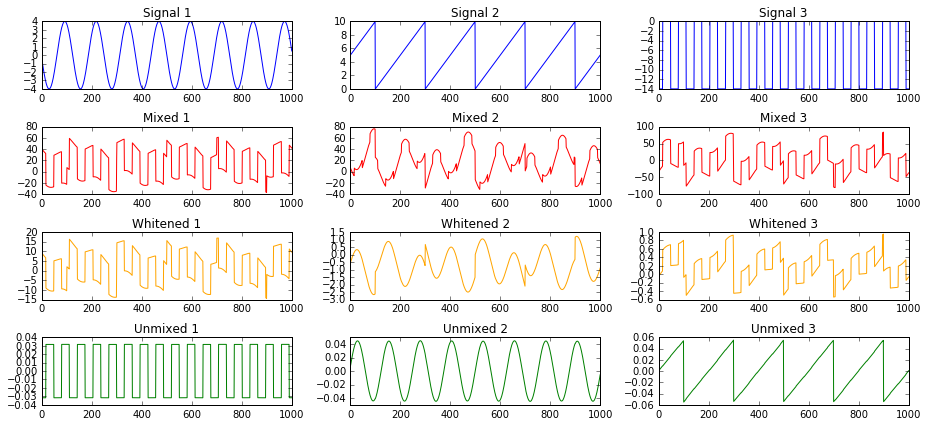

In [3]:
# 8.1. (a), (b), (c)
signals = generate_signals()
A = np.array([[2, -3, -4], [7, 5, 1], [-4, 7, 5]])
mixed = A.dot(signals)
execute_and_plot_ica(signals, A, mixed, G='exp')

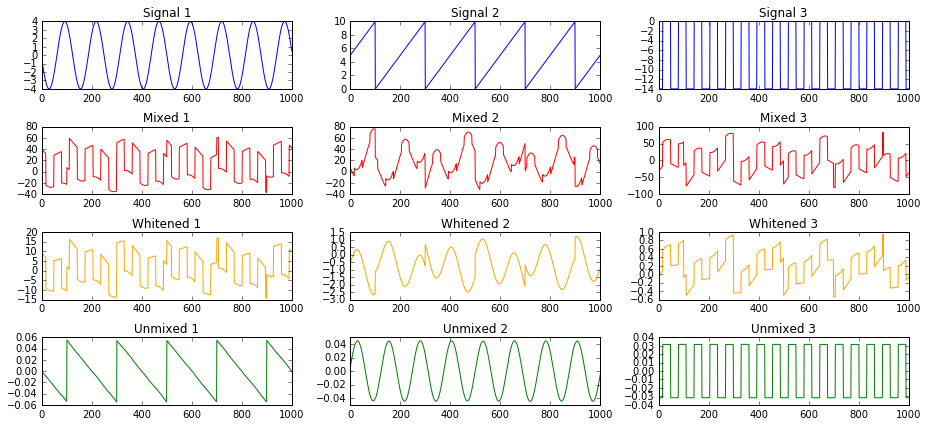

In [4]:
# 8.1. (d)
execute_and_plot_ica(signals, A, mixed, G='exp')

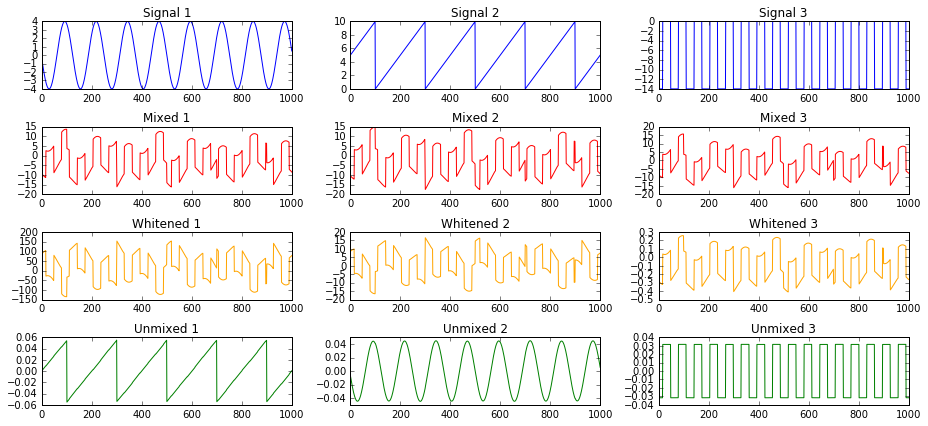

In [5]:
# 8.1. (e)
# det(A) = -123 ; det(A2) = -0.02  (det(singular_matrix) = 0)
A2 = np.array([[1, 1, 1], [1, 1.1, 1.1], [1, 1.2, 1]])
mixed = A2.dot(signals)
execute_and_plot_ica(signals, A2, mixed)

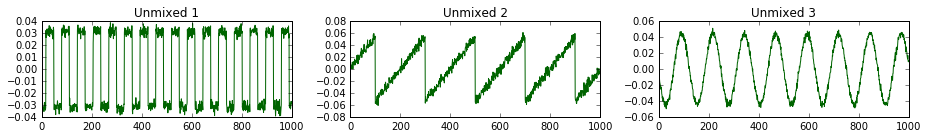

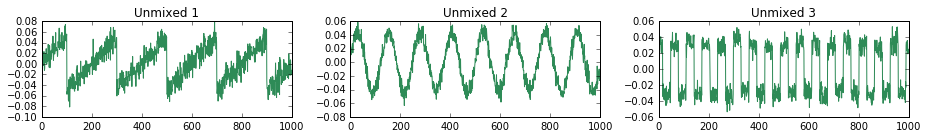

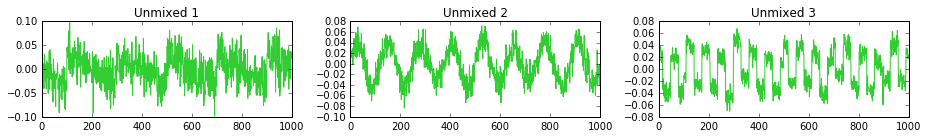

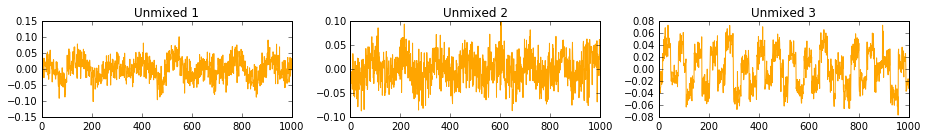

In [6]:
# 8.1. (f)

def gaussian_noise(variance):
    scale = np.sqrt(variance)
    size = np.prod(mixed.shape)
    noise = np.random.RandomState(seed).normal(0, scale, size).reshape(mixed.shape)
    return noise

mixed = A.dot(signals) + gaussian_noise(1)
execute_and_plot_ica(signals, A, mixed, minimalView=True, color='darkgreen')

mixed = A.dot(signals) + gaussian_noise(10)
execute_and_plot_ica(signals, A, mixed, minimalView=True, color='seagreen')

mixed = A.dot(signals) + gaussian_noise(100)
execute_and_plot_ica(signals, A, mixed, minimalView=True, color='limegreen')

mixed = A.dot(signals) + gaussian_noise(500)
execute_and_plot_ica(signals, A, mixed, minimalView=True, color='orange')

In [23]:
#8.2
# setup data for ICA
sound1 = np.loadtxt('sounds/sound1.dat')
sound2 = np.loadtxt('sounds/sound2.dat')
sounds = np.concatenate([[sound1, sound2]], axis=1)

#create 100 different mixing matrices
As = np.zeros([1000,2,2])
n = As.shape[0] 
for i in np.arange(n):
    A = np.linalg.inv(np.random.RandomState().rand(2,2))
    As[i] = A

In [24]:
# [from previous exercises] setup functions for ICA
def sigmoid(y):
    return 0.5*np.tanh(0.5*y)+0.5 #overflow-safe version

def psi(y):
    return 1 - 2 * sigmoid(y)

def update_natural(W, x):
    n = x.shape[0]
    
    phee = psi(W.dot(x)).reshape(n, 1)
    delta_W = np.dot(phee.dot(np.dot(W, x).reshape(1, n)), W)
    delta_W = delta_W + W  # multiplied out delta function
    for i in range(n):  # Bell-Sejnowski solution
        delta_W[i, i] = 0
    return delta_W

def plot(ax, data, **kwargs):
    ax.plot(data, **kwargs)
    ax.set_title(kwargs['label'])
    scipy.io.wavfile.write(kwargs['label'] + '.wav', 8192, data),

def online_ica(X0, lambda_= 0.9999, epsilon = 0.001, eta = 0.01):
    X = X0[:,np.random.RandomState(seed+1).permutation(X0.shape[1])]
    X -= X.mean(axis=1).reshape((2, 1))
    
    n = X.shape[0]  # Number of sources
    W = np.linalg.inv(np.random.RandomState(seed+1).rand(n, n))
    for i in range(n):  # Bell-Sejnowski solution
        W[i, i] = 1
    time = 0
    while eta > epsilon:
        example = X.T[time % X.shape[1]]
        eta = eta * lambda_
        W += eta * update_natural(W, example)
        time += 1
#     print("Calculated unmixing matrix in {} steps".format(time))
    return W.dot(X0)

def fast_ica(X):
    ica = FastICA(n_components=2)
    S_ = ica.fit_transform(X.T)  # Reconstruct signals
    A_ = ica.mixing_  # Get estimated mixing matrix
    return S_.T #return unmixed signals

seed = 13  # seed for random states to get always the same result

In [25]:
times = np.zeros([n,2])
dets = np.zeros([n,1])

for i, A in enumerate(As):    
    dets[i] = np.linalg.det(A)
    X = A.dot(sounds)
    
    start_time = time.time()
    unmixed_onlineica = online_ica(X)
    times[i,0] = (time.time() - start_time)
#     print("online ica took %s seconds" % (time.time() - start_time))

    start_time = time.time()
    unmixed_fastica = fast_ica(X)
    times[i,1] = (time.time() - start_time)
#     print("fast ica took %s seconds" % (time.time() - start_time))

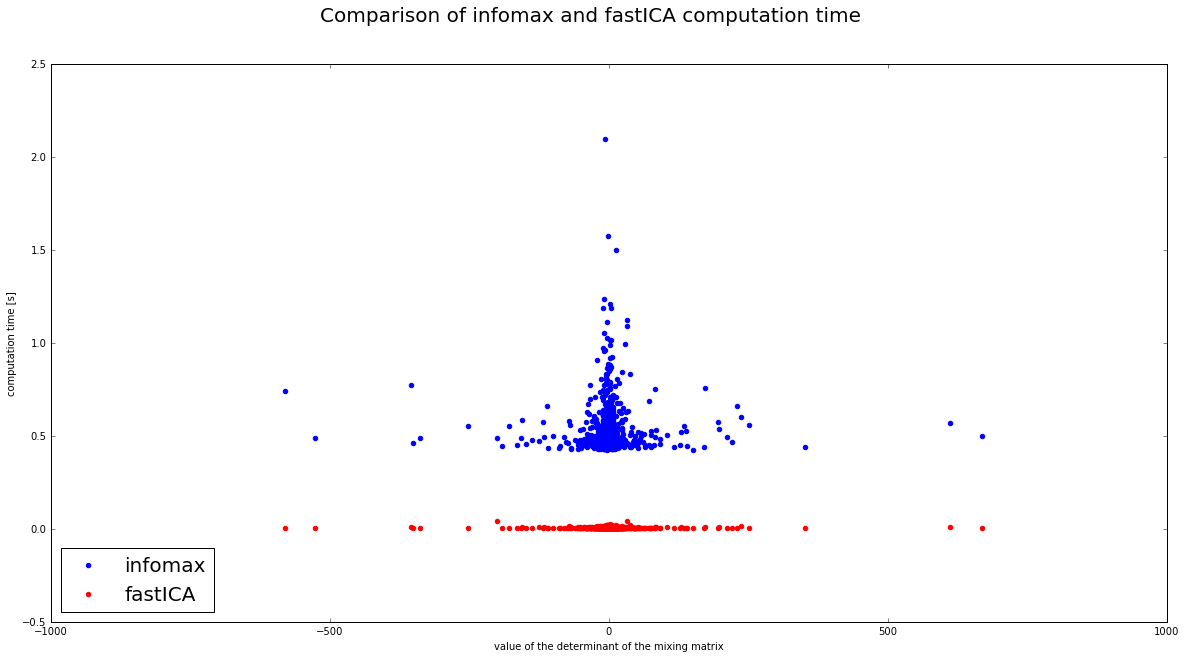

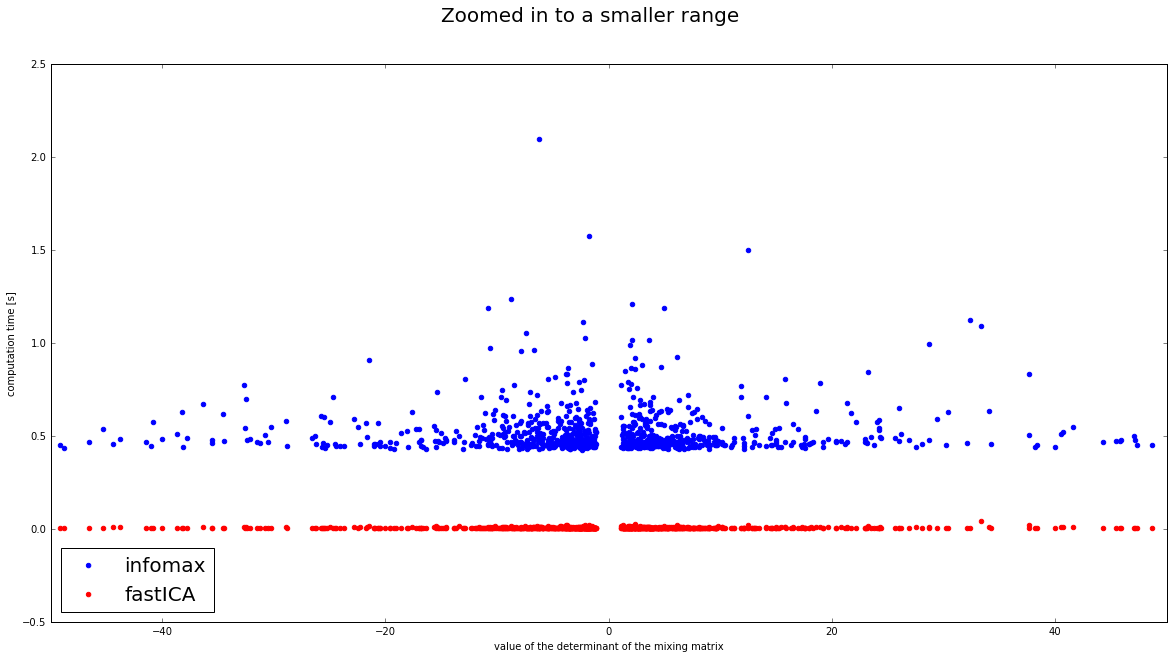

In [27]:
fig = plt.figure(0,figsize=(20,10))
plt.xlim([-1000,1000])
fig.suptitle('Comparison of infomax and fastICA computation time', fontsize=20)
infomax = plt.scatter(dets,times[:,0],color='blue')
fastica = plt.scatter(dets,times[:,1],color='red')
plt.xlabel('value of the determinant of the mixing matrix')
plt.ylabel('computation time [s]')

plt.legend((infomax, fastica),
           ('infomax','fastICA'),
           scatterpoints=1,
           loc='lower left',
           fontsize=20)

fig = plt.figure(1,figsize=(20,10))
fig.suptitle('Zoomed in to a smaller range', fontsize=20)
plt.xlim([-50,50])
infomax = plt.scatter(dets,times[:,0],color='blue')
fastica = plt.scatter(dets,times[:,1],color='red')
plt.xlabel('value of the determinant of the mixing matrix')
plt.ylabel('computation time [s]')
plt.xlabel('value of the determinant of the mixing matrix')
plt.ylabel('computation time [s]')

plt.legend((infomax, fastica),
           ('infomax','fastICA'),
           scatterpoints=1,
           loc='lower left',
           fontsize=20);

 The plots demonstrate that fastICA is significantly faster and more robust w.r.t to the difficulty of the problem

In [28]:
#8.3
IMSHOW_ARGS = dict(cmap=plt.cm.gray, interpolation='nearest')
 
def sample_patches(images, count=5000, size=16):
    patches = np.empty((count, size * size))
    for i in range(count):
        image = random.choice(images)
        x = int(random.random() * (image.shape[0] - size))
        y = int(random.random() * (image.shape[1] - size))
        patches[i] = image[x: x + size, y: y + size].flatten()
    return patches
 
def show_patches(patches, rows, cols, title='Patches', size=10, labels=None, drop_percentiles=0):
    assert len(patches) == rows * cols
    # Normalize.
    if drop_percentiles:
        drop = min(1, int(len(patches) * drop_percentiles / 100))
        middle = patches[drop: len(patches) - drop]
        min_, max_ = middle.min(), middle.max()
        patches = 256 * ((patches - min_) / (max_ - min_))
    # Plot.
    fig, ax = plt.subplots(
        nrows=rows, ncols=cols, figsize=(size, size / cols * rows),
        subplot_kw={'xticks': [], 'yticks': []})
    fig.suptitle(title)
    ax = ax.reshape((rows, cols))
    for x, y in itertools.product(range(rows), range(cols)):
        index = x * cols + y
        patch = patches[index]
        ax[x, y].get_xaxis().set_visible(False)
        ax[x, y].imshow(patch, **IMSHOW_ARGS)
        if labels:
            ax[x, y].set_title(labels[index])
    plt.show()

In [29]:
def compute_negentropy(data):
    mean = data.mean(axis=0)
    variance = np.var(data, axis=1)
    gaussian = 0.5 * np.log(2 * np.pi * np.e * variance ** 2) / np.log(2)
    real = np.log(data).mean(axis=1)
    return gaussian - real
 
def sort_features(mixing):
    negentropy = compute_negentropy(mixing)
    mixing = mixing[-np.argsort(negentropy)]
    return mixing
 
def compare_features(datasets, names):
    mixings = []
    labels = []
    for data, label in zip(datasets, names):
        ica = FastICA(max_iter=2000)
        ica.fit(data)
        mixings.append(ica.mixing_)
        labels.append('ICA ' + label)
    for data, label in zip(datasets, names):
        pca = PCA(data.shape[1])
        pca.fit(data)
        mixings.append(ica.components_)
        labels.append('PCA ' + label)
    mixings = np.array(mixings)
    print(mixings.shape)
    show_patches(mixings, 2, len(datasets), labels=labels)

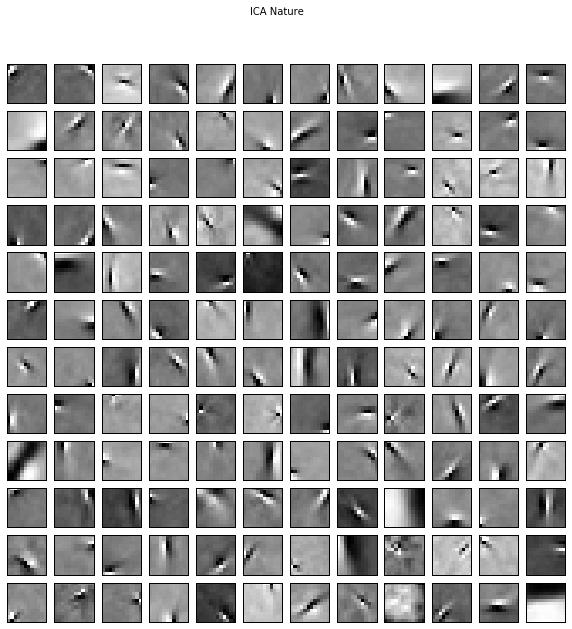

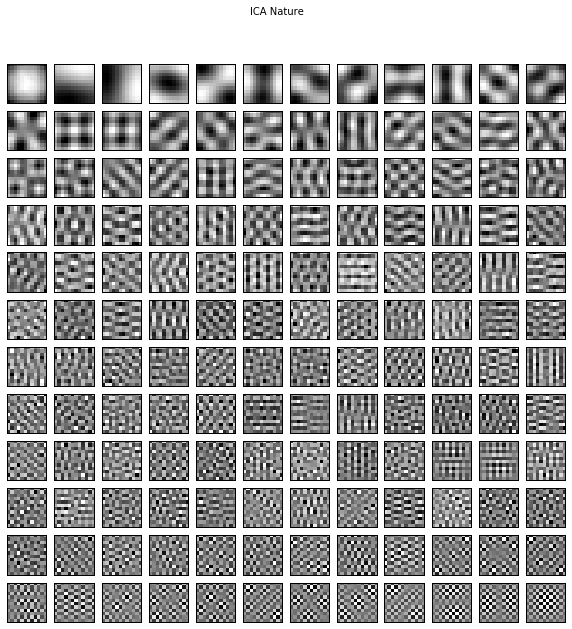

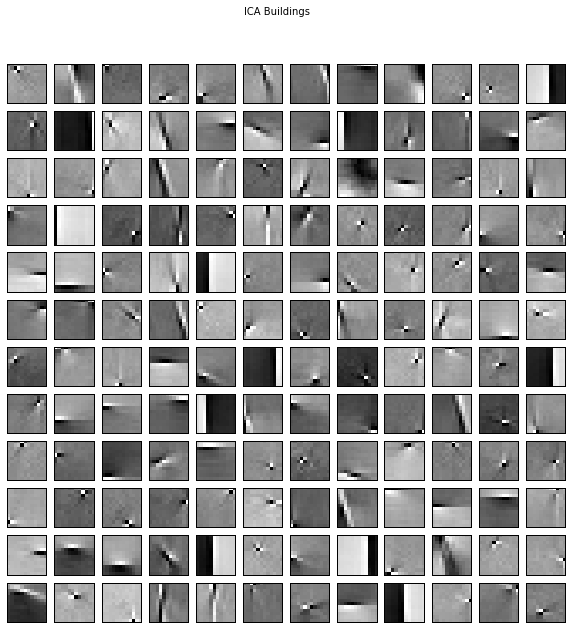

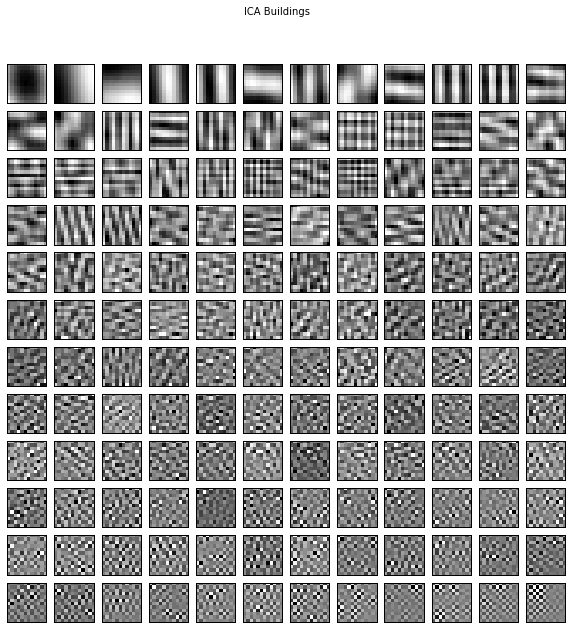

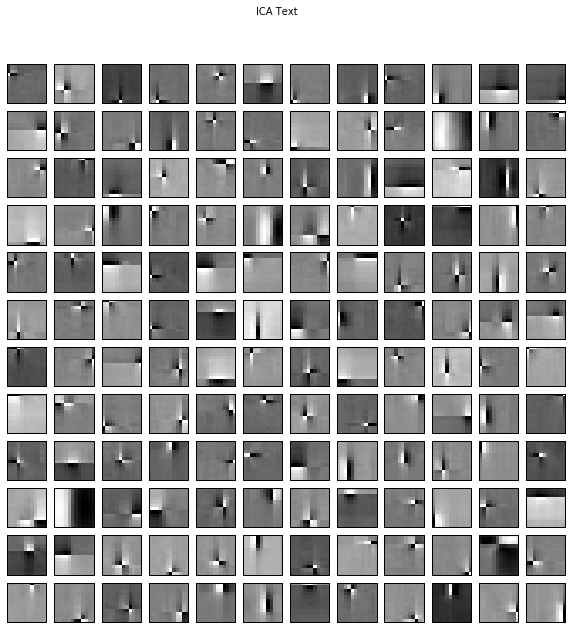

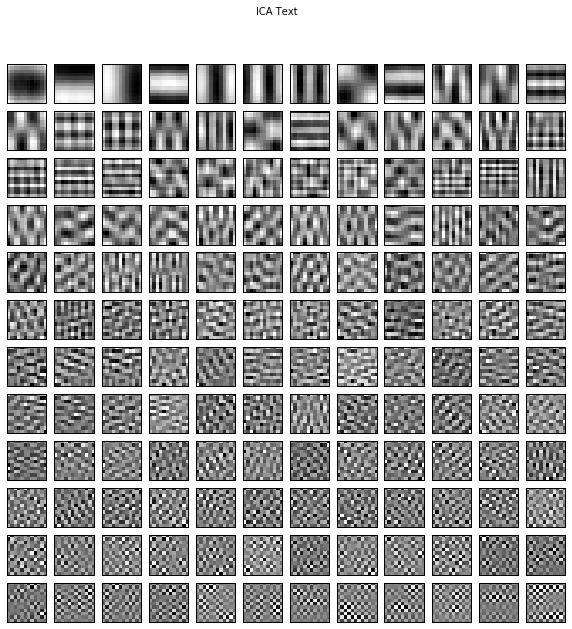

In [30]:
import glob
from sklearn.decomposition import FastICA, PCA
from scipy import ndimage
 
nature = [ndimage.imread(x) for x in glob.glob('imgpca/n*.jpg')]
buildings = [ndimage.imread(x) for x in glob.glob('imgpca/b*.jpg')]
text = [ndimage.imread(x) for x in glob.glob('imgpca/t*.jpg')]
 
count = 20000
nature = sample_patches(nature, count=count, size=12)
buildings = sample_patches(buildings, count=count, size=12)
text = sample_patches(text, count=count, size=12)

def show_ica_features(data, label):
    ica = FastICA(max_iter=2000)
    ica.fit(data)
    mixing = sort_features(ica.mixing_.T)
    mixing = mixing.reshape((-1, 12, 12))
    show_patches(mixing, 12, 12, 'ICA ' + label, drop_percentiles=5)

def show_pca_features(data, label):
    pca = PCA()
    pca.fit(data)
    components = pca.components_
    components = components.reshape((-1, 12, 12))
    show_patches(components, 12, 12, 'ICA ' + label, drop_percentiles=5)

show_ica_features(nature, 'Nature')
show_pca_features(nature, 'Nature')
show_ica_features(buildings, 'Buildings')
show_pca_features(buildings, 'Buildings')
show_ica_features(text, 'Text')
show_pca_features(text, 'Text')